프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.(어떠한 방법을 사용했는지 적어주세요.)

2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.	데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.	U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.	10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.


# 데이터 불러오기

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import time
import imageio
from IPython import display

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/project/cityscapes/'
train_data_path = os.path.join(data_dir, 'train/')
val_data_path = os.path.join(data_dir, 'val/')

print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

number of train examples : 1001
number of validation examples : 5


6개의 사진을 임의로 선택하여 시각화

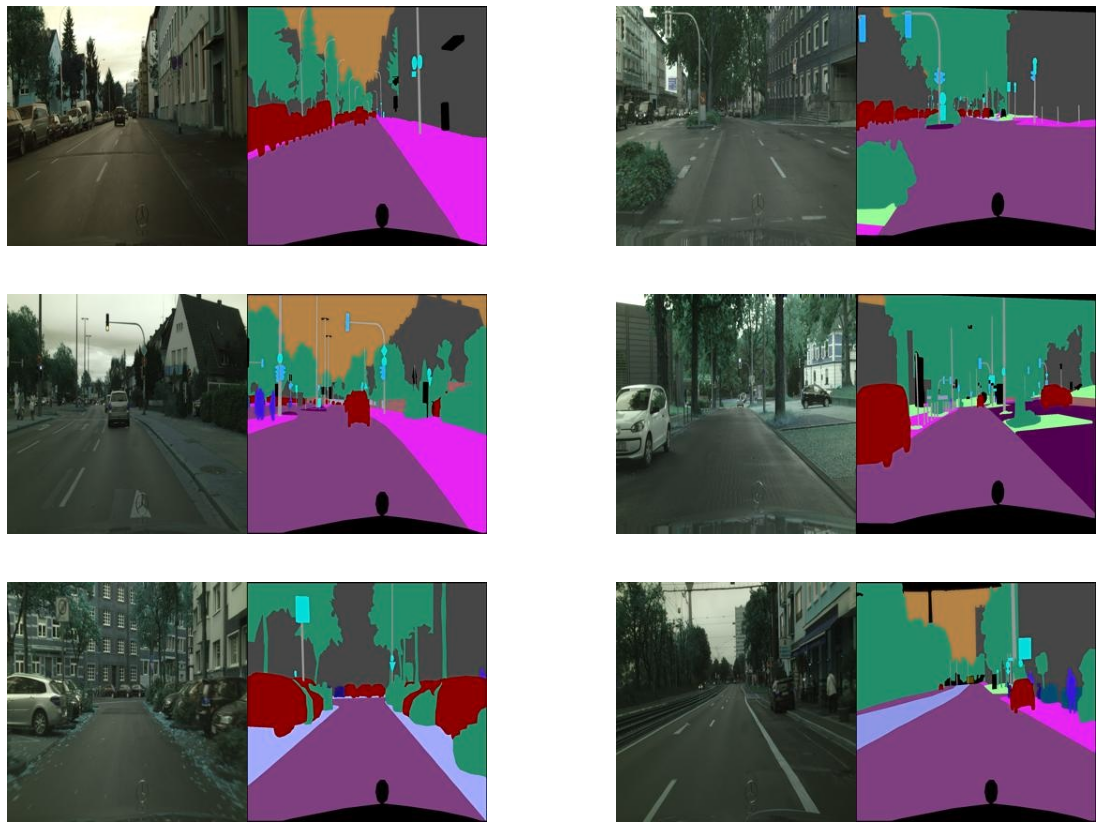

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.axis('off')
    plt.imshow(img)

이미지 크기 확인도 해본다.

(높이, 너비, 채널)(height, width, channels)순으로
높이가 256 픽셀, 너비가 512 픽셀이며 각 픽셀당 3개의 채널(RGB)을 가지는 이미지다.

In [4]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


이미지를 나누어본다.

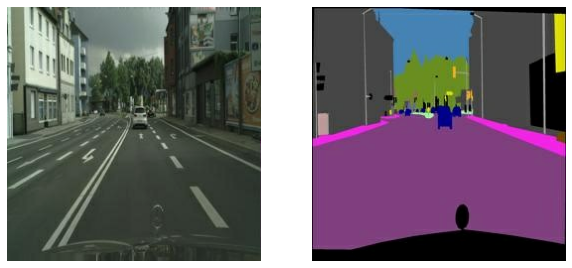

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(denormalize(colored))

_pad 텐서는 3차원의 형태를 가지고 있고 각 차원은 [30, 30], [30, 30], [0, 0]으로 정의되어 있다.

첫번째 차원인 높이 방향으로의 패딩을 나타내며 [30, 30]은 상단과 하단에 각각 30씩의 패딩을 추가하라는 의미이다.

두 번째 차원은 너비 방향으로의 패딩을 나타내며 [30, 30]은 좌측과 우측에 각각 30씩의 패딩을 추가하라는 의미이다.

세 번째 차원은 깊이 방향으로의 패딩을 나타내며 [0, 0]은 패딩을 추가하지 말라는 의미이다.

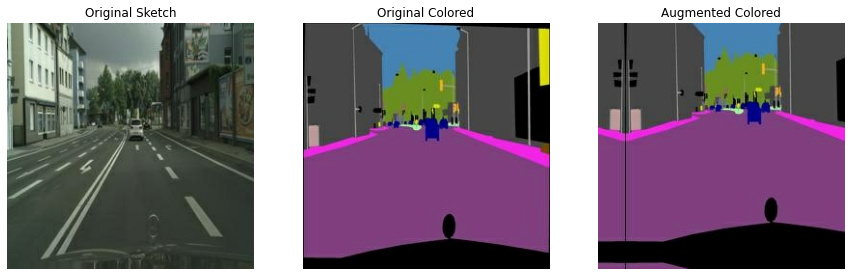

In [6]:
@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    if tf.random.uniform(()) < 0.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = tf.image.random_crop(padded, size=[256, 256, 6])
    
    out = tf.image.random_flip_left_right(out)
    out = tf.image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < 0.5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = tf.image.rot90(out, k=degree)
    
    return out[..., :3], out[..., 3:]

# 데이터 로드 및 augmentation 적용
f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)
aug_sketch, aug_colored = apply_augmentation(sketch, colored)

# 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.axis('off'); plt.imshow(denormalize(sketch)); plt.title('Original Sketch')
plt.subplot(1, 3, 2); plt.axis('off'); plt.imshow(denormalize(colored)); plt.title('Original Colored')
plt.subplot(1, 3, 3); plt.axis('off'); plt.imshow(denormalize(aug_colored)); plt.title('Augmented Colored')
plt.show()


뒤집기 (horizontal flip)기법을 사용한 augmentation

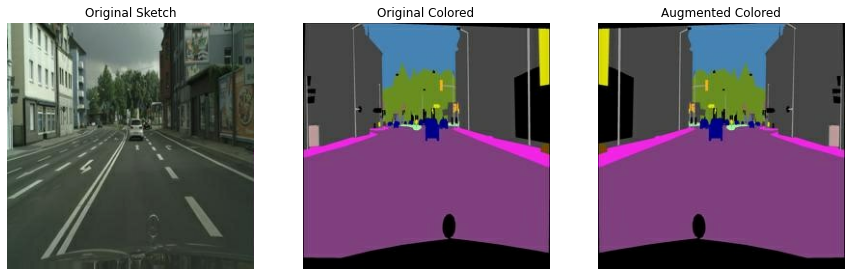

In [7]:
def augment_image(sketch, colored):
    # 뒤집기 (horizontal flip)
    if tf.random.uniform(()) > 0.5:
        sketch = tf.image.flip_left_right(sketch)
        colored = tf.image.flip_left_right(colored)
    
    # 랜덤한 각도로 회전
    angle = tf.random.uniform([], minval=-0.5, maxval=0.5)
    sketch = tf.image.rot90(sketch, k=tf.cast(angle / 0.5, tf.int32))
    colored = tf.image.rot90(colored, k=tf.cast(angle / 0.5, tf.int32))
    
    return sketch, colored

# 데이터 로드 및 augmentation 적용
f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)
aug_sketch, aug_colored = augment_image(sketch, colored)

# 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.axis('off'); plt.imshow(denormalize(sketch)); plt.title('Original Sketch')
plt.subplot(1, 3, 2); plt.axis('off'); plt.imshow(denormalize(colored)); plt.title('Original Colored')
plt.subplot(1, 3, 3); plt.axis('off'); plt.imshow(denormalize(aug_colored)); plt.title('Augmented Colored')
plt.show()


채도와 색조 조절하는 augmentation

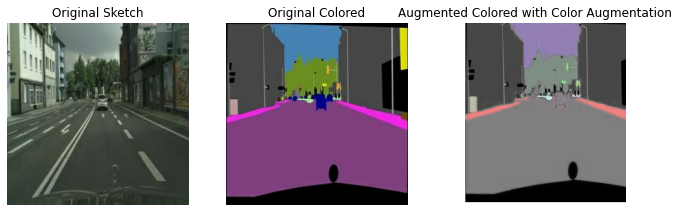

In [8]:
@tf.function()
def apply_color_augmentation(image):
    # 랜덤하게 채도 조절
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    
    # 랜덤하게 색조 조절
    image = tf.image.random_hue(image, max_delta=0.2)
    
    return image

# 데이터 로드 및 augmentation 적용
f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)
aug_sketch, aug_colored = apply_augmentation(sketch, colored)
aug_colored = apply_color_augmentation(aug_colored)

# 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1); plt.axis('off'); plt.imshow(denormalize(sketch)); plt.title('Original Sketch')
plt.subplot(1, 4, 2); plt.axis('off'); plt.imshow(denormalize(colored)); plt.title('Original Colored')
plt.subplot(1, 4, 3); plt.axis('off'); plt.imshow(denormalize(aug_colored)); plt.title('Augmented Colored with Color Augmentation')
plt.show()


학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해본다.

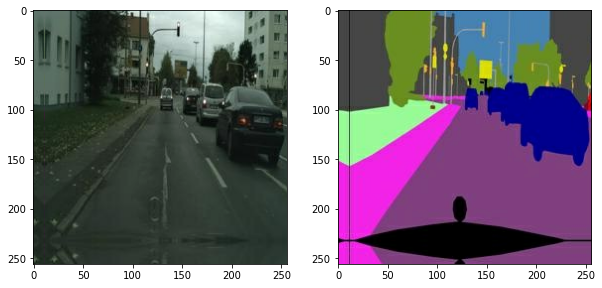

In [9]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Generator 구성

EncodeBlock 구현

EncodeBlock은 인코더 네트워크에서 하나의 블록으로 주로 이미지의 공간적인 특징을 추출하는 역할을 한다. 여러 개의 이러한 블록이 쌓여 전체 인코더 네트워크를 형성하게 된다.

In [10]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [11]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

DecodeBlock 구현

In [13]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [14]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

U-Net Generator 구현

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
generator = UNetGenerator()
generator.get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

DiscBlock 구현

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

Discriminator 구현

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
                n_filters=f, 
                stride=2 if i < 3 else 1, 
                custom_pad= i >= 3,
                use_bn= i != 0 and i != 4, 
                act= i < 4
            ))
        self.sigmoid = layers.Activation(tf.keras.activations.sigmoid)
    
    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [20]:
discriminator = Discriminator()
discriminator.get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

# 모델 학습

손실 함수 사용

In [21]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

optimizer 설정

In [22]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


하나의 배치 크기만큼 데이터를 입력했을 때 가중치 1회 업데이트

In [23]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

학습 진행

In [24]:
EPOCHS = 3

generator = UNetGenerator()
discriminator = Discriminator()

gene_losses = []
l1_losses = []
disc_losses = []


for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # Append the loss values
        gene_losses.append(g_loss.numpy())
        l1_losses.append(l1_loss.numpy())
        disc_losses.append(d_loss.numpy())

        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")



EPOCH[1] - STEP[10]                     
Generator_loss:0.9059                     
L1_loss:0.3017                     
Discriminator_loss:1.1616

EPOCH[1] - STEP[20]                     
Generator_loss:1.1382                     
L1_loss:0.3294                     
Discriminator_loss:0.9068

EPOCH[1] - STEP[30]                     
Generator_loss:1.2821                     
L1_loss:0.2552                     
Discriminator_loss:0.9067

EPOCH[1] - STEP[40]                     
Generator_loss:1.6240                     
L1_loss:0.3476                     
Discriminator_loss:0.7486

EPOCH[1] - STEP[50]                     
Generator_loss:1.6030                     
L1_loss:0.2601                     
Discriminator_loss:0.7012

EPOCH[1] - STEP[60]                     
Generator_loss:1.2758                     
L1_loss:0.2254                     
Discriminator_loss:0.7121

EPOCH[1] - STEP[70]                     
Generator_loss:1.7846                     
L1_loss:0.2455                    

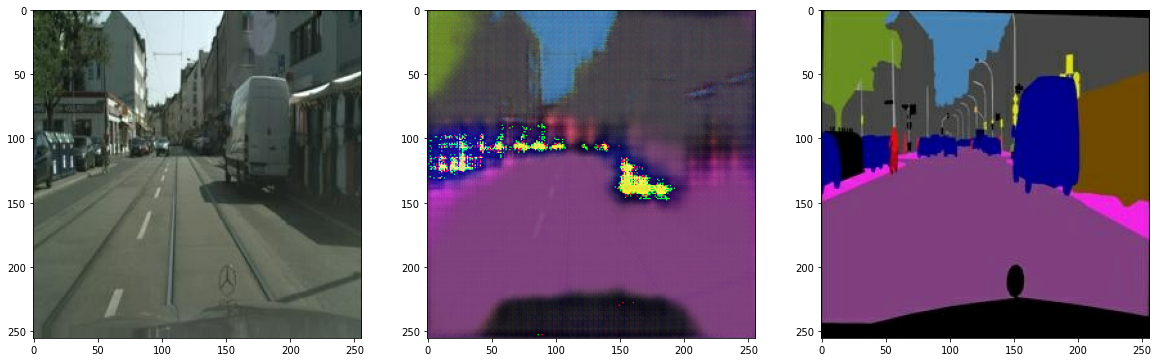

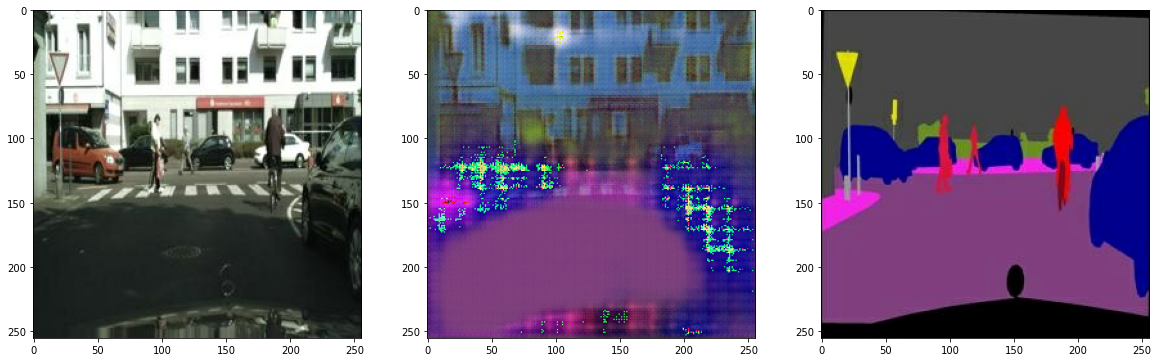

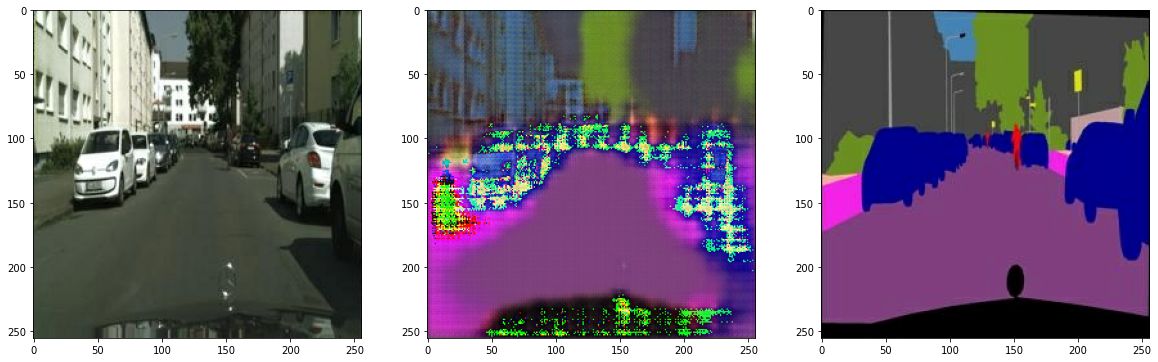

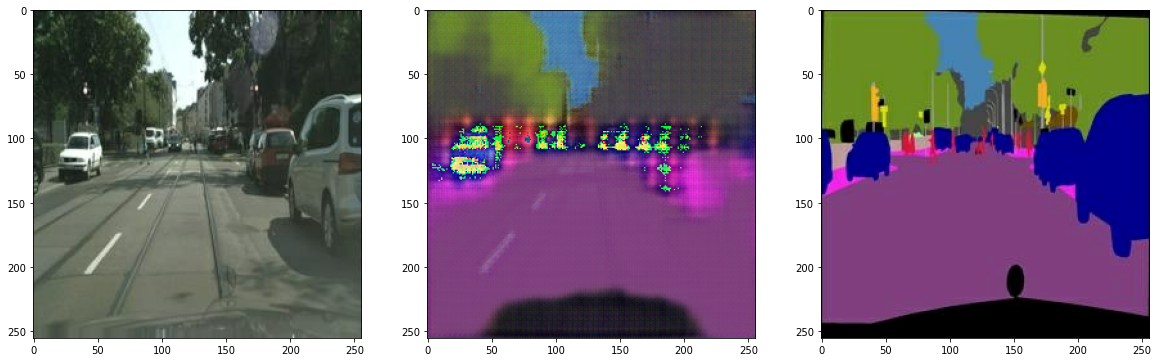

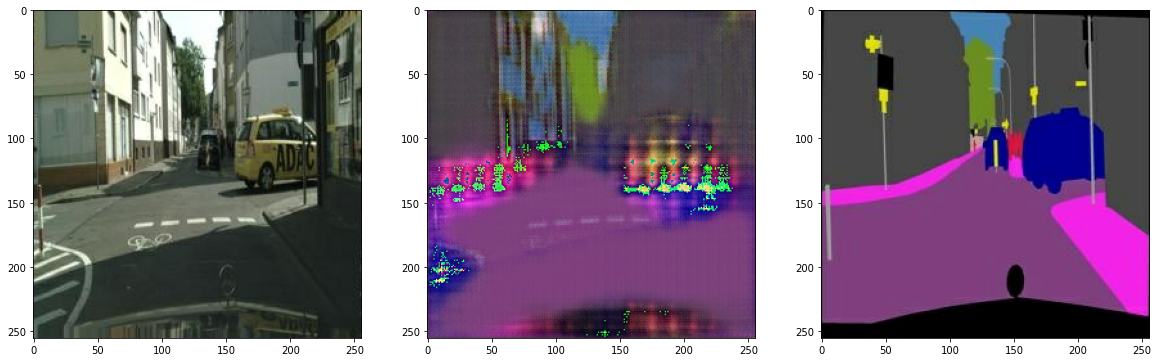

In [25]:
test_ind = 1

for i in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

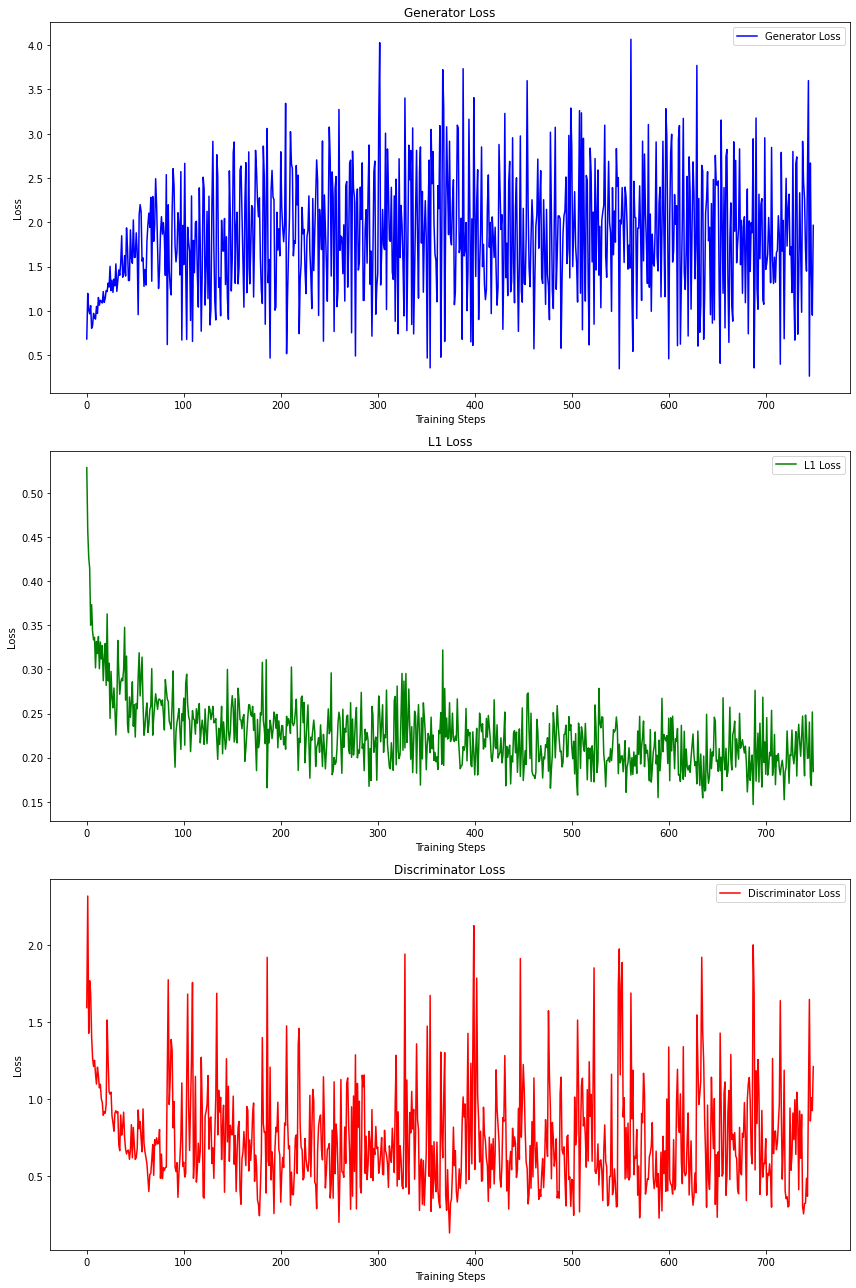

In [26]:
# Plotting each loss value separately with individual subplots
plt.figure(figsize=(12, 18))

# Generator Loss
plt.subplot(3, 1, 1)
plt.plot(gene_losses, label='Generator Loss', color='blue')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# L1 Loss
plt.subplot(3, 1, 2)
plt.plot(l1_losses, label='L1 Loss', color='green')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('L1 Loss')
plt.legend()

# Discriminator Loss
plt.subplot(3, 1, 3)
plt.plot(disc_losses, label='Discriminator Loss', color='red')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

plt.tight_layout()
plt.show()
